In this example, we use variational auto encoders (VAE) to encode images in the mnist hand-digit dataset.

using an encoder network, we convert the images into a low dimension space (latent space). this space is define by two parameters: mu and sigma.
then the decoder network receives the mu and sigma and generates a hand-digit image.
the combination of the encoder and decoder networks is called VAE.

the loss function of VAE consists of this two: the reconstruction loss and KL-divergence loss.

reconstruction loss means that the output of the decoder network should be equal to encoder's output.

The KL divergence term encourages the distribution of latent variables (latent space) to be close to a known distribution, typically a multivariate normal distribution. This helps regularize the latent space and ensures that it has certain desirable properties. The KL divergence term acts as a regularization term, preventing the model from learning an overly complex or unconstrained latent space.

the goal of this process is to encode the 10 classes of the mnist dataset into seperable clusters in a low dimensional space (latent space). the seperable clusters helps to easily generate desired hand-digit numbers using the decoder network. this goal is also achievable by using conditional-GAN networks which you can find in the repository.

<img src="https://www.andrew.cmu.edu/user/xihuang/blog/ae_vae/vae.png" alt="VAE Architecture" />

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Lambda, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def load_dataset():
    ds_train, ds_test = tfds.load(name='mnist',
                                split=['train','test'],
                                shuffle_files=True,
                                as_supervised=True,
                                read_config=tfds.ReadConfig(shuffle_seed=100))

    def preprocess(image, label):
        img = tf.cast(image, dtype=tf.float32) / 255
        return img, label
    
    ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(len(ds_train), seed=42, reshuffle_each_iteration=False)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

    ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.cache()
    ds_test = ds_test.batch(128)
    ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
    
    return ds_train, ds_test

In [3]:
def define_encoder(input_shape, latent_dim):
    inp = Input(shape=input_shape, name='input')
    x = Conv2D(64, 3, padding='same', activation='relu')(inp)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 2, padding='same', activation='relu', name='last_conv')(x)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    z_mu = Dense(latent_dim, name='latent_mu')(x)
    z_sigma = Dense(latent_dim, name='latent_sigma')(x) 

    def sample_z(args):
      z_mu, z_sigma = args
      eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
      return z_mu + K.exp(z_sigma / 2) * eps

    z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

    encoder = tf.keras.models.Model(inp, [z_mu, z_sigma, z], name='encoder')

    return encoder

In [4]:
def define_decoder(encoder_model):
    latent_dim = encoder_model.output_shape[0][1]
    conv_shape = encoder_model.get_layer('last_conv').output_shape[1:]
    
    inp = Input(shape=(latent_dim,))
    x = Dense(16, activation='relu')(inp)
    x = Dense(32, activation='relu')(x)
    x = Dense(np.prod(conv_shape), activation='relu')(x)
    x = Reshape((conv_shape[0], conv_shape[1], conv_shape[2]))(x)
    x = Conv2D(128, 2, padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = Conv2D(1, 1, padding='same', activation='sigmoid')(x)
    decoder = tf.keras.models.Model(inp, x, name='decoder')

    return decoder

In [5]:
def define_vae(input_shape, latent_dim):
    encoder = define_encoder(input_shape, latent_dim)
    decoder = define_decoder(encoder)
    
    x = encoder.get_layer('input').input
    latent_mu = encoder.get_layer('latent_mu').output
    latent_sigma = encoder.get_layer('latent_sigma').output
    z = encoder.get_layer('z').output
    z_decoded = decoder(z)

    def vae_loss(inputs, outputs, latent_mu, latent_sigma):
        x = K.flatten(inputs)
        z_decoded = K.flatten(outputs)
        reconstruction_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        KL_loss = -5e-4 * K.mean(1 + latent_sigma - K.square(latent_mu) - K.exp(latent_sigma), axis=-1)
        return K.mean(reconstruction_loss + KL_loss)

    vae = tf.keras.models.Model(x, z_decoded)
    vae.add_loss(vae_loss(x, z_decoded, latent_mu, latent_sigma))

    vae.compile(optimizer='adam', loss=None)    
        
    return vae, encoder, decoder

In [7]:
vae, encoder, decoder = define_vae((28,28,1), 2)
# vae.summary(expand_nested=True)

In [8]:
ds_train, ds_test = load_dataset()

In [120]:
vae.fit(ds_train, validation_data=ds_test, epochs=10)

Epoch 1/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1747 - val_loss: 0.1798
Epoch 2/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1742 - val_loss: 0.1794
Epoch 3/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1738 - val_loss: 0.1808
Epoch 4/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1736 - val_loss: 0.1807
Epoch 5/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1733 - val_loss: 0.1802
Epoch 6/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1730 - val_loss: 0.1807
Epoch 7/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1727 - val_loss: 0.1808
Epoch 8/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1726 - val_loss: 0.1808
Epoch 9/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1724 - val_loss: 0.1810
Epoch 10/10
469/469 [==============================] - 12s 25ms/step - loss: 0.172

79/79 [==============================] - 0s 2ms/step


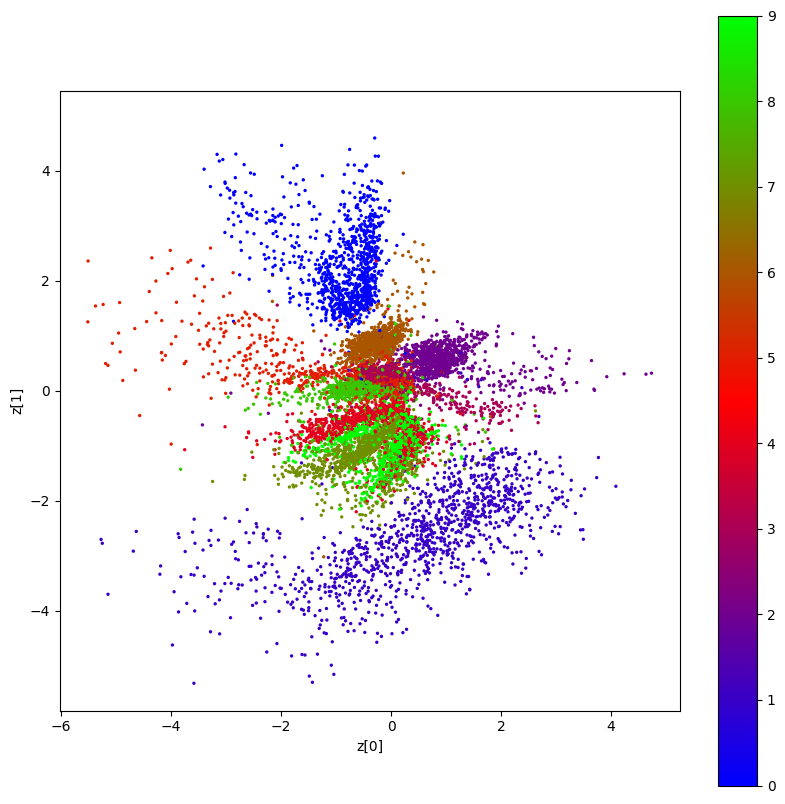

In [121]:
# plotting the images of the test dataset in the latent space.
_, _, z = encoder.predict(ds_test)
labels = np.concatenate([i[1] for i in ds_test.as_numpy_iterator()])

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

s = axs.scatter(z[:, 0], z[:, 1], c=labels, cmap='brg', s=2)
axs.set_xlabel('z[0]')
axs.set_ylabel('z[1]')
plt.colorbar(s)
axs.axis('square')

plt.show()

29/29 [==============================] - 0s 7ms/step


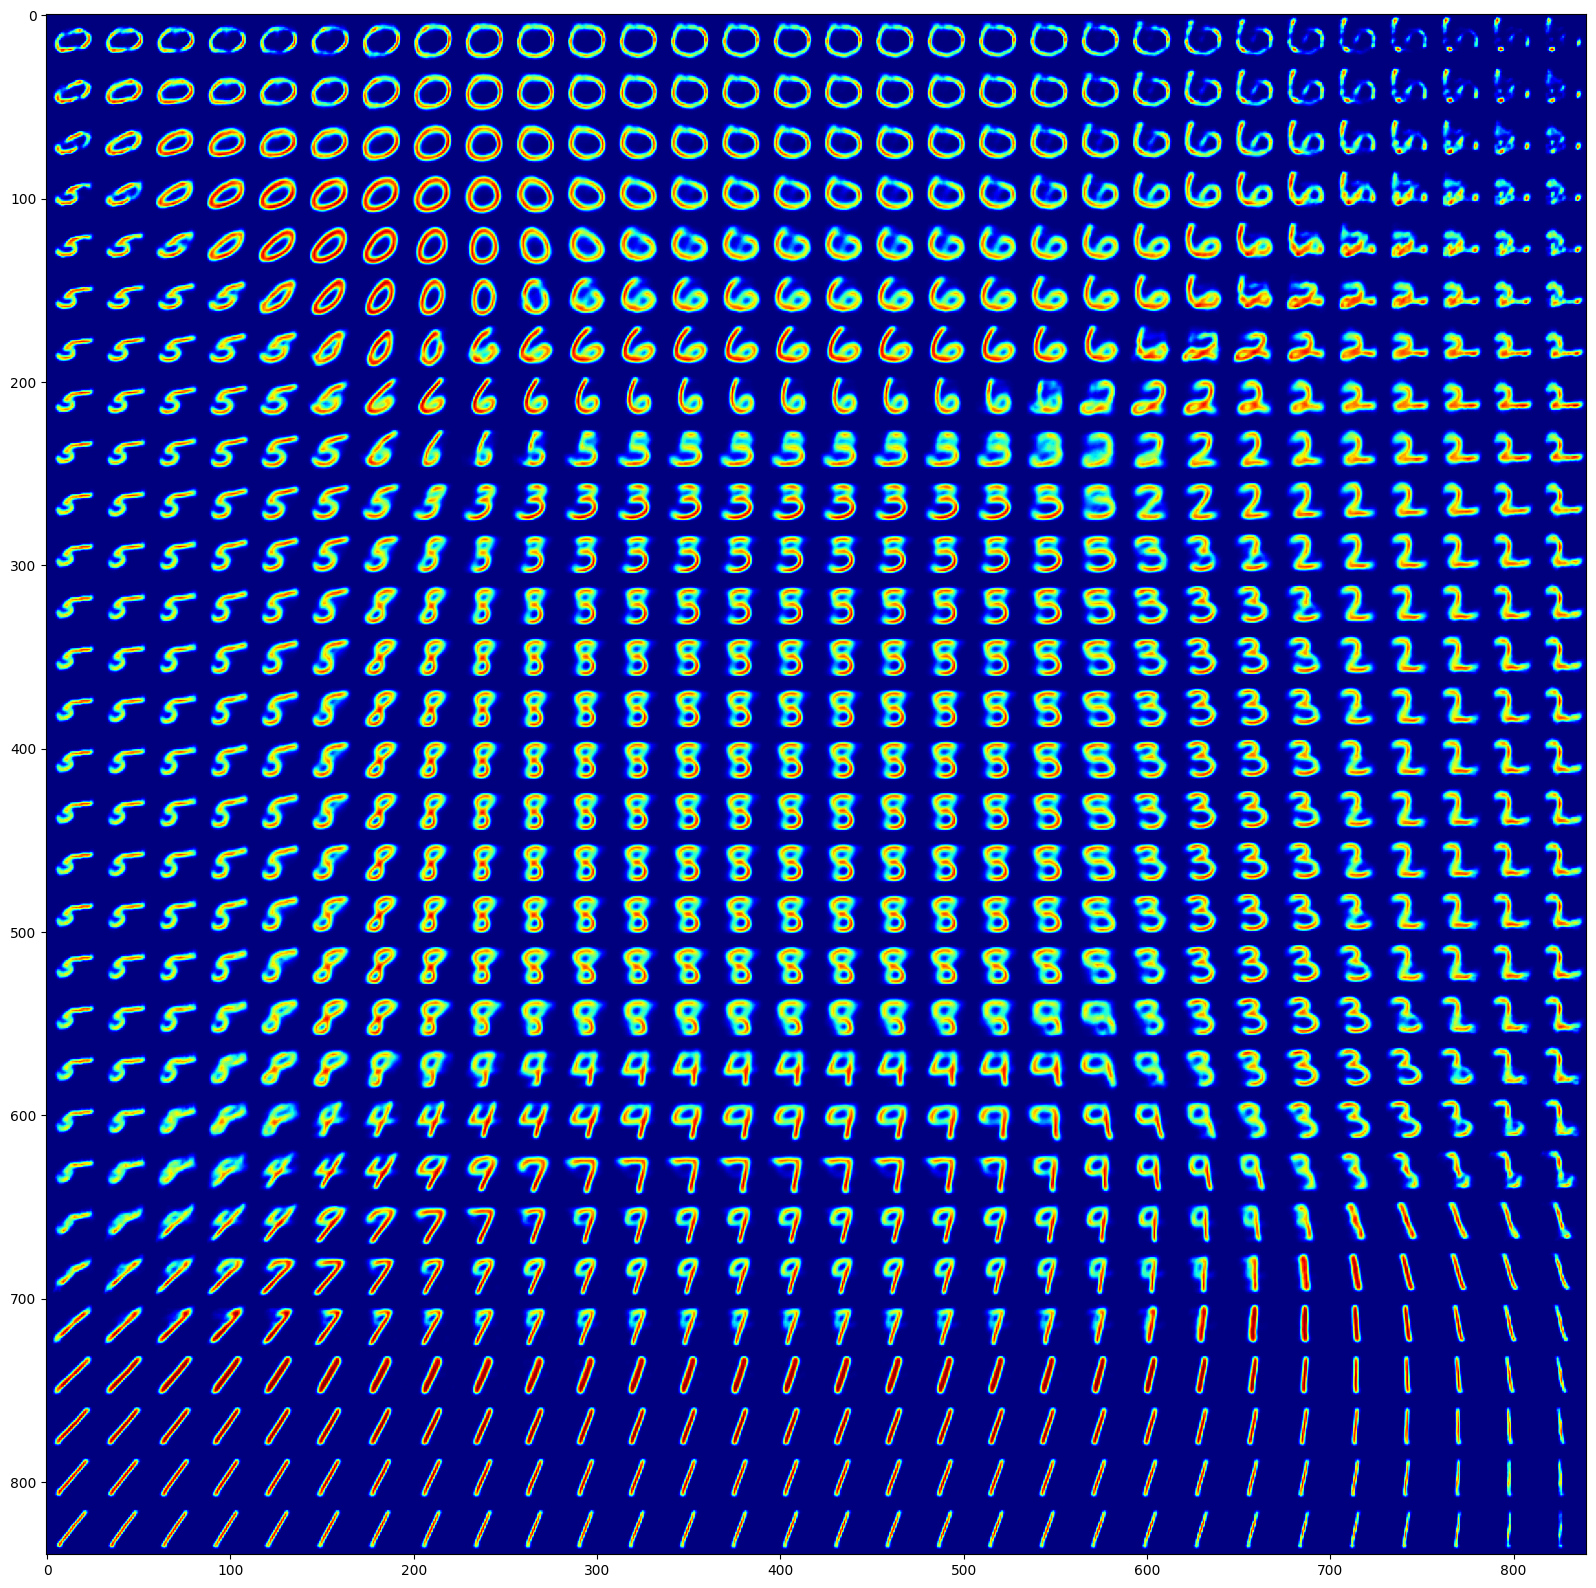

In [125]:
n = 30  # generate 30x30 digits
all_digits_image = np.zeros((28 * n, 28 * n, 1))

# Generate a grid using meshgrid
x_grid, y_grid = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
x_grid = x_grid * np.square(np.linspace(-np.sqrt(5), np.sqrt(5), n)).reshape((1,n))
y_grid = y_grid * np.square(np.linspace(-np.sqrt(5), np.sqrt(5), n)).reshape((n,1))

grid = np.concatenate((x_grid[...,np.newaxis], y_grid[...,np.newaxis]), axis=-1)
grid = grid.reshape((n*n,2))

x_decoded = decoder.predict(grid)

# decoder for each square in the grid
c = 0
for i in range(n-1,-1,-1):
    for j in range(n):
        digit = x_decoded[c,...].reshape(28, 28, 1)
        all_digits_image[i * 28: (i + 1) * 28,
               j * 28: (j + 1) * 28] = digit
        c += 1

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='jet')
plt.show()